In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shopee-sentiment-analysis/train.csv
/kaggle/input/shopee-sentiment-analysis/sampleSubmission.csv
/kaggle/input/shopee-sentiment-analysis/test.csv


# 1. Load data

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

path = '/kaggle/input/shopee-sentiment-analysis/'
train_df = pd.read_csv('/kaggle/input/shopee-sentiment-analysis/train.csv')
test_df = pd.read_csv('/kaggle/input/shopee-sentiment-analysis/test.csv')
sampleSubmission_df = pd.read_csv('/kaggle/input/shopee-sentiment-analysis/sampleSubmission.csv')

# 2. Preprocess data

## 2.1. Filtering emoji

In [3]:
import emoji  # https://pypi.org/project/emoji/

def emoji_cleaning(text):
    # Change emoji to text
    text = emoji.demojize(text).replace(":", " ")
    
    # Delete repeated emoji
    tokenizer = text.split()
    repeated_list = []
    
    for word in tokenizer:
        if word not in repeated_list:
            repeated_list.append(word)
    
    text = ' '.join(text for text in repeated_list)
    text = text.replace("_", " ").replace("-", " ")
    return text

In [4]:
have_emoji_train_idx = []
have_emoji_test_idx = []

for idx, review in enumerate(train_df['review']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        have_emoji_train_idx.append(idx)
        
for idx, review in enumerate(test_df['review']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        have_emoji_test_idx.append(idx)
        
# emoji_cleaning
train_df.loc[have_emoji_train_idx, 'review'] = train_df.loc[have_emoji_train_idx, 'review'].apply(emoji_cleaning)
test_df.loc[have_emoji_test_idx, 'review'] = test_df.loc[have_emoji_test_idx, 'review'].apply(emoji_cleaning)

## 2.2. Cleaning text
* emotion
* repeated word characters (in bahasa)
* punctuation
* shortened words
* noisy text

In [5]:
import re # regular expression

def review_cleaning(text):
    
    # delete lowercase and newline
    text = text.lower()
    text = re.sub(r'\n', '', text)
    
    # change emoticon to text
    text = re.sub(r':\(', 'dislike', text)
    text = re.sub(r': \(\(', 'dislike', text)
    text = re.sub(r':, \(', 'dislike', text)
    text = re.sub(r':\)', 'smile', text)
    text = re.sub(r';\)', 'smile', text)
    text = re.sub(r':\)\)\)', 'smile', text)
    text = re.sub(r':\)\)\)\)\)\)', 'smile', text)
    text = re.sub(r'=\)\)\)\)', 'smile', text)
    
    # delete punctuation
    text = re.sub('[^a-z0-9 ]', ' ', text)
    
    tokenizer = text.split()
    
    return ' '.join([text for text in tokenizer])

train_df['review'] = train_df['review'].apply(review_cleaning)
test_df['review'] = test_df['review'].apply(review_cleaning)

In [6]:
repeated_rows_train = []
repeated_rows_test = []

for idx, review in enumerate(train_df['review']):
    if re.match(r'\w*(\w)\1+', review):
        repeated_rows_train.append(idx)
        
for idx, review in enumerate(test_df['review']):
    if re.match(r'\w*(\w)\1+', review):
        repeated_rows_test.append(idx)
        
def delete_repeated_char(text):
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    return text

train_df.loc[repeated_rows_train, 'review'] = train_df.loc[repeated_rows_train, 'review'].apply(delete_repeated_char)
test_df.loc[repeated_rows_test, 'review'] = test_df.loc[repeated_rows_test, 'review'].apply(delete_repeated_char)

In [7]:
# drop the row that has noisy text or mislabeled rating
noisy_row = [31, 50, 2235, 5244, 10409, 11748, 12384, 14395, 15215, 17629, 20819, 23691, 32089, 39532, 40530, 43954, 48186, 50500, 55834, 60088,
             60442, 61095, 62982, 63803, 67464, 70791, 74861, 73636, 74119, 76275, 79789, 85745, 91058, 91663, 91800, 93204, 99295, 100903, 101177, 103155,
             109166, 109566, 109651, 109724, 110115, 110441, 111461, 113175, 115782, 116903, 118099, 118328, 118414, 119071, 125338, 125340, 129496, 129640, 
             132027, 138212, 131626, 134715, 133248, 136217, 141377, 143707, 145045, 146485, 37301]

train_df.drop(noisy_row, inplace=True)

In [8]:
def recover_shortened_words(text):
    
    # put \b (boundary) for avoid the characters in the word to be replaced
    # I only make a few examples here, you can add if you're interested :)
    
    text = re.sub(r'\bapaa\b', 'apa', text)
    
    text = re.sub(r'\bbsk\b', 'besok', text)
    text = re.sub(r'\bbrngnya\b', 'barangnya', text)
    text = re.sub(r'\bbrp\b', 'berapa', text)
    text = re.sub(r'\bbgt\b', 'banget', text)
    text = re.sub(r'\bbngt\b', 'banget', text)
    text = re.sub(r'\bgini\b', 'begini', text)
    text = re.sub(r'\bbrg\b', 'barang', text)
    
    text = re.sub(r'\bdtg\b', 'datang', text)
    text = re.sub(r'\bd\b', 'di', text)
    text = re.sub(r'\bsdh\b', 'sudah', text)
    text = re.sub(r'\bdri\b', 'dari', text)
    text = re.sub(r'\bdsni\b', 'disini', text)
    
    text = re.sub(r'\bgk\b', 'gak', text)
    
    text = re.sub(r'\bhrs\b', 'harus', text)
    
    text = re.sub(r'\bjd\b', 'jadi', text)
    text = re.sub(r'\bjg\b', 'juga', text)
    text = re.sub(r'\bjgn\b', 'jangan', text)
    
    text = re.sub(r'\blg\b', 'lagi', text)
    text = re.sub(r'\blgi\b', 'lagi', text)
    text = re.sub(r'\blbh\b', 'lebih', text)
    text = re.sub(r'\blbih\b', 'lebih', text)
    
    text = re.sub(r'\bmksh\b', 'makasih', text)
    text = re.sub(r'\bmna\b', 'mana', text)
    
    text = re.sub(r'\borg\b', 'orang', text)
    
    text = re.sub(r'\bpjg\b', 'panjang', text)
    
    text = re.sub(r'\bka\b', 'kakak', text)
    text = re.sub(r'\bkk\b', 'kakak', text)
    text = re.sub(r'\bklo\b', 'kalau', text)
    text = re.sub(r'\bkmrn\b', 'kemarin', text)
    text = re.sub(r'\bkmrin\b', 'kemarin', text)
    text = re.sub(r'\bknp\b', 'kenapa', text)
    text = re.sub(r'\bkcil\b', 'kecil', text)
    
    text = re.sub(r'\bgmn\b', 'gimana', text)
    text = re.sub(r'\bgmna\b', 'gimana', text)
    
    text = re.sub(r'\btp\b', 'tapi', text)
    text = re.sub(r'\btq\b', 'thanks', text)
    text = re.sub(r'\btks\b', 'thanks', text)
    text = re.sub(r'\btlg\b', 'tolong', text)
    text = re.sub(r'\bgk\b', 'tidak', text)
    text = re.sub(r'\bgak\b', 'tidak', text)
    text = re.sub(r'\bgpp\b', 'tidak apa apa', text)
    text = re.sub(r'\bgapapa\b', 'tidak apa apa', text)
    text = re.sub(r'\bga\b', 'tidak', text)
    text = re.sub(r'\btgl\b', 'tanggal', text)
    text = re.sub(r'\btggl\b', 'tanggal', text)
    text = re.sub(r'\bgamau\b', 'tidak mau', text)
    
    text = re.sub(r'\bsy\b', 'saya', text)
    text = re.sub(r'\bsis\b', 'sister', text)
    text = re.sub(r'\bsdgkan\b', 'sedangkan', text)
    text = re.sub(r'\bmdh2n\b', 'semoga', text)
    text = re.sub(r'\bsmoga\b', 'semoga', text)
    text = re.sub(r'\bsmpai\b', 'sampai', text)
    text = re.sub(r'\bnympe\b', 'sampai', text)
    text = re.sub(r'\bdah\b', 'sudah', text)
    
    text = re.sub(r'\bberkali2\b', 'repeated', text)
    
    text = re.sub(r'\byg\b', 'yang', text)
    
    return text

train_df['review'] = train_df['review'].apply(recover_shortened_words)

# 3. Build Dataset

In [10]:
from fastai.text import *
bs=8
data_clas = (TextList.from_csv(path, csv_name='train.csv', cols='review')
        .split_by_rand_pct(0.1)
        .label_from_df(cols='rating')
        .add_test(TextList.from_csv(path, csv_name='test.csv', cols='review'))
        .databunch(bs=bs))

# 4. Classifier

In [37]:
learn = text_classifier_learner(data_clas, Transformer, drop_mult=0.4, model_dir='/kaggle/output', pretrained=False)

AttributeError: 'str' object has no attribute 'to'

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


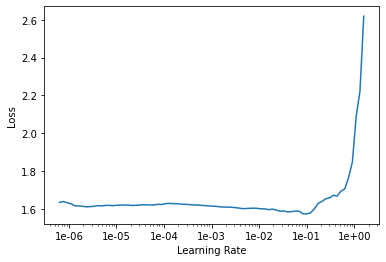

In [12]:
learn.lr_find()
learn.recorder.plot()

# 5. Train model

In [13]:
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.260983,1.269235,0.411893,10:24


In [14]:
learn.save('first')

In [15]:
learn.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (132130 items)
x: TextList
xxbos xxmaj xxunk replace broken glass , broken chargernya,xxbos xxmaj nyesel bngt dsni shopping antecedent photo message pictures gk according xxunk existing collagen super fit nyampe xxunk my house open ehhh collagen contents even in the face pdahal jg description super existing collagen xxunk writing my check lg in photo captions already ma xxmaj the change ma pictures that the face .,xxbos xxmaj sent a light blue suit goods ga want a refund,xxbos xxmaj pendants came with dents and scratches on its surface . xxmaj the coating looks like it will change colour quickly .,xxbos xxmaj dg yg depending being sent in photos
y: CategoryList
1,1,1,1,1
Path: /kaggle/input/shopee-sentiment-analysis;

Valid: LabelList (14681 items)
x: TextList
xxbos xxmaj two people order but your mic . xxmaj just one night without a charger and xxmaj mike ung ... xxmaj please arrange for wire xxmaj naman check first on bgo ideliver 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


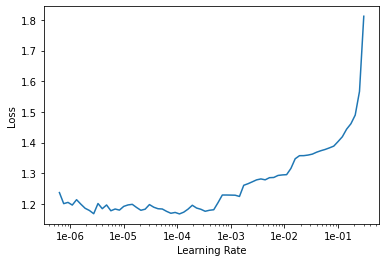

In [30]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.freeze_to(-2)

In [23]:
learn.fit_one_cycle(1, slice(5e-4/(2.6**4), 5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.274258,1.158922,0.439820,12:45


In [24]:
learn.save('second')

In [25]:
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (132130 items)
x: TextList
xxbos xxmaj xxunk replace broken glass , broken chargernya,xxbos xxmaj nyesel bngt dsni shopping antecedent photo message pictures gk according xxunk existing collagen super fit nyampe xxunk my house open ehhh collagen contents even in the face pdahal jg description super existing collagen xxunk writing my check lg in photo captions already ma xxmaj the change ma pictures that the face .,xxbos xxmaj sent a light blue suit goods ga want a refund,xxbos xxmaj pendants came with dents and scratches on its surface . xxmaj the coating looks like it will change colour quickly .,xxbos xxmaj dg yg depending being sent in photos
y: CategoryList
1,1,1,1,1
Path: /kaggle/input/shopee-sentiment-analysis;

Valid: LabelList (14681 items)
x: TextList
xxbos xxmaj two people order but your mic . xxmaj just one night without a charger and xxmaj mike ung ... xxmaj please arrange for wire xxmaj naman check first on bgo ideliver 

# 6. Make prediction

In [26]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test, ordered=True)
ratings = np.argmax(preds, 1)
print(min(ratings))

tensor(0)


# 7. Submission

In [27]:
submission_preds = ratings + 1
submission_df = pd.DataFrame({'review_id': test_df['review_id'], 'rating': submission_preds})
submission_df.to_csv('submission.csv', header=True, index=False)

In [28]:
submission_df.head()

,review_id,rating
0,1,3
1,2,3
2,3,5
3,4,3
4,5,5


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd739d14b10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd739d16790>]], dtype=object)

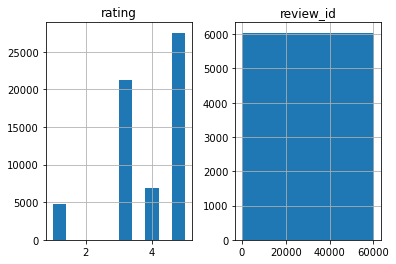

In [29]:
submission_df.hist()